2.245225770735456e40

In [1]:
using PMDPs
using PMDPs.LP
using DrWatson
using RandomNumbers.Xorshifts
using MCTS
using POMDPTools
using DiscreteValueIteration

using Formatting

import Base.show

# using Plots; pyplot()
using Plots
gr()
using Distributions
using ProgressMeter


using POMDPs
using DataFrames
using Printf

using Plots.PlotMeasures

In [2]:
ENV["COLUMNS"]=10000

10000

In [3]:
include(srcdir("MDPPricing.jl"))
include(srcdir("reporting.jl"))

format_result_table (generic function with 1 method)

In [4]:
SOLVERS = Dict("flatrate"=> "Flatrate", "hindsight"=> "Oracle", "mcts"=>"MCTS", "vi"=>"VI")

Dict{String, String} with 4 entries:
  "hindsight" => "Oracle"
  "mcts"      => "MCTS"
  "flatrate"  => "Flatrate"
  "vi"        => "VI"

# Reconstructing plots from the paper

In [5]:
λ =[ 5.606461791, 7.246819385, 8.856408742, 10.12648652, 11.30679669, 12.98650257, 13.29649141, 14.83661005, 16.3367346, 18.54665055, 19.73678626, 21.31685288, 22.13670877, 23.28689651, 24.0870552]
nt = [3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24]
k = nt.*8
err₁(λ, k) =  k - (k+λ)*(exp(-λ/k))
err₂(λ, k) =  λ*exp(-λ/k) + (λ-k)*(1-exp(-λ/k))

err_1 = err₁.(λ, k)
err_2 = err₂.(λ, k)

15-element Vector{Float64}:
 0.6066950470053847
 0.7619796835558912
 0.9119234893206896
 0.9968673264779371
 1.0683644505021608
 1.2327976464665813
 1.155541127229771
 1.2945329497558085
 1.3144398304918532
 1.454249637947239
 1.4463584394447473
 1.5027482274677197
 1.4631092671637553
 1.4748110837305823
 1.4496519661781306

In [30]:
plotattr(:Series)
plotattr("color")

Defined Series attributes are:
arrow, bar_edges, bar_position, bar_width, bins, colorbar_entry, connections, contour_labels, contours, extra_kwargs, fill_z, fillalpha, fillcolor, fillrange, fillstyle, group, hover, label, levels, line_z, linealpha, linecolor, linestyle, linewidth, marker_z, markeralpha, markercolor, markershape, markersize, markerstrokealpha, markerstrokecolor, markerstrokestyle, markerstrokewidth, normalize, orientation, permute, primary, quiver, ribbon, series_annotations, seriesalpha, seriescolor, seriestype, show_empty_bins, smooth, stride, subplot, weights, x, xerror, y, yerror, z, z_order, zerror
:seriescolor

The base color for this series. `:auto` (the default) will select a color from the subplot's `color_palette`, based on the order it was added to the subplot. Also describes the colormap for surfaces.

Aliases: (:c, :cmap, :color, :colormap, :colour, :seriescolors).

Type: Union{Integer, Symbol, ColorSchemes.ColorScheme, Colorant}.

`Series` attribute, defau

In [60]:
using ColorSchemes

length(ColorSchemes.inferno.colors)
zmax = err₂(30,30)
zmax/30 * length(ColorSchemes.inferno.colors)

94.17713693988922

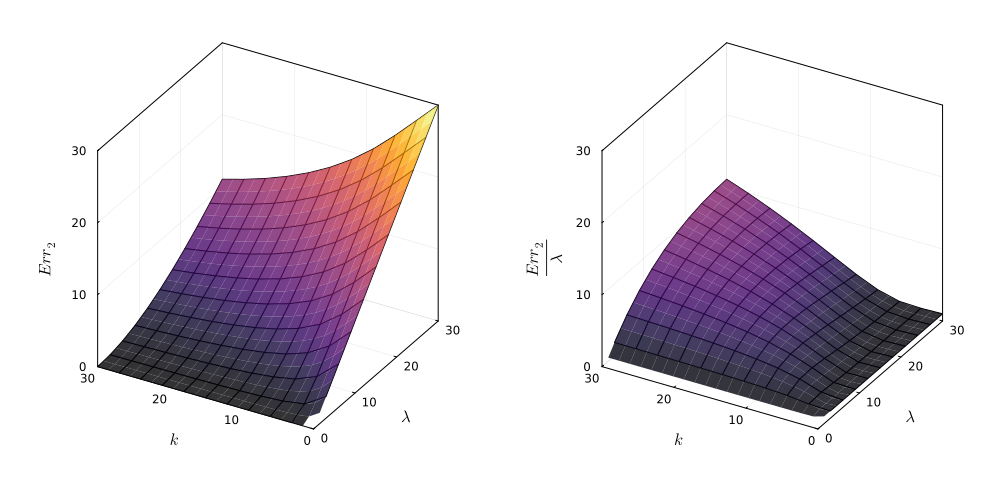

"c:\\Users\\mrkos\\scth\\projects\\MDPPricing\\notebooks\\fig_error2_analytical.pdf"

In [68]:
p1 = wireframe(0:3:30, 0:3:30, (k, λ) -> λ*exp(-λ/k) + (λ-k)*(1-exp(-λ/k)), 
    xflip=true, 
    framestyle=:box, 
    linewidth=10,
    # alpha=0.5,
    contour=true,
    # camera = (30,30), 
    xlabel="\$k\$", ylabel="\$\\lambda\$", zlabel="\$Err_2\$", 
    # title="Visualization of \$Err_2(\\lambda, k)\$"
    )
surface!(p1, 0:3/2:30, 0:3/2:30, (k, λ) -> λ*exp(-λ/k) + (λ-k)*(1-exp(-λ/k)), 
    # framestyle=:box, 
    # color=:magma,
    color=ColorSchemes.inferno.colors,
    alpha=0.8,
    xflip=true,
    colorbar=false
    )

p2 = wireframe(0:3:30, 0:3:30, (k, λ) -> λ*exp(-λ/k) + (λ-k)*(1-exp(-λ/k))/λ, 
    xflip=true, 
    framestyle=:box, 
    linewidth=10,
    # alpha=0.5,
    contour=true,
    zlim=(0,30),
    clims=(0.,30.),
    # camera = (30,30), 
    xlabel="\$k\$", ylabel="\$\\lambda\$", zlabel="\$\\frac{Err_2}{\\lambda}\$",
    # title="Visualization of \$Err_2(\\lambda, k)/\\lambda\$"
    )
surface!(p2, 0:3/2:30, 0:3/2:30, (k, λ) -> λ*exp(-λ/k) + (λ-k)*(1-exp(-λ/k))/λ, 
    # framestyle=:box, 
    clims=(0.,30.),
    color=ColorSchemes.inferno.colors[1:94],
    # st = :contourf
    alpha=0.8,
    xflip=true,
    colorbar=false,
    zlim=(0,30)
    )

p = plot(p1, p2, layout=(1,2), size=(1000, 500))
display(p)
savefig("fig_error2_analytical.pdf")

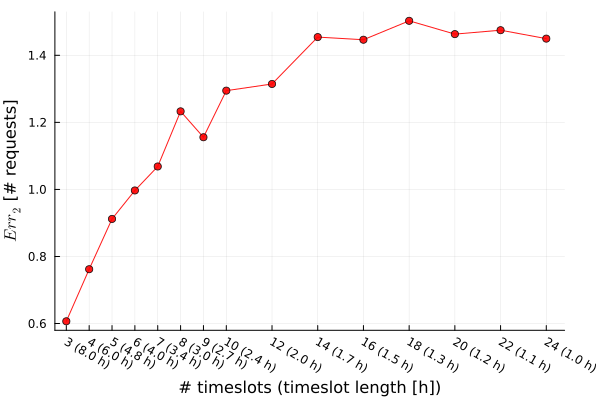

LoadError: UndefVarError: `savefig` not defined

In [7]:
x_vals=nt
p = Plots.plot(legend=:topleft, foreground_color_legend = nothing, xrotation=-30, bottom_margin=3mm, right_margin=7mm)
plot!(p, x_vals, err_2, label=false, marker=true, alpha=0.9, color=:red)

xticks!(p, (x_vals, map(v->"$(v[1]) ($(@sprintf("%.1f", v[2])) h)", zip(x_vals , 24 ./ x_vals))))
xlabel!(p, "# timeslots (timeslot length [h])")
xlims!(p, 2.5, 24.8)
# yticks!(p, [5,10,15,20])
ylabel!(p, "\$Err_2\$ [# requests]")
# ylims!(p, 4.5, 24.6)
display(p)

savefig("fig_error2_nᵣ.pdf")

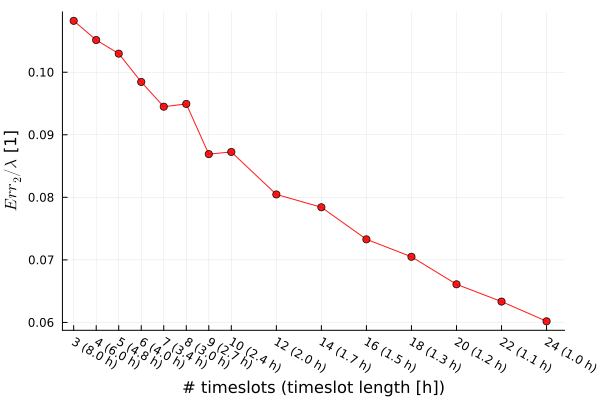

"c:\\Users\\mrkos\\scth\\projects\\MDPPricing\\notebooks\\fig_error2lambda_nᵣ.pdf"

In [84]:
x_vals=nt
p = plot(legend=:topleft, foreground_color_legend = nothing, xrotation=-30, bottom_margin=3mm, right_margin=7mm)
plot!(p, x_vals, err_2./λ, label=false, marker=true, alpha=0.9, color=:red)

xticks!(p, (x_vals, map(v->"$(v[1]) ($(@sprintf("%.1f", v[2])) h)", zip(x_vals , 24 ./ x_vals))))
xlabel!(p, "# timeslots (timeslot length [h])")
xlims!(p, 2.5, 24.8)
# yticks!(p, [5,10,15,20])
ylabel!(p, "\$Err_2/\\lambda\$ [1]")
# ylims!(p, 4.5, 24.6)
display(p)

savefig("fig_error2lambda_nᵣ.pdf")


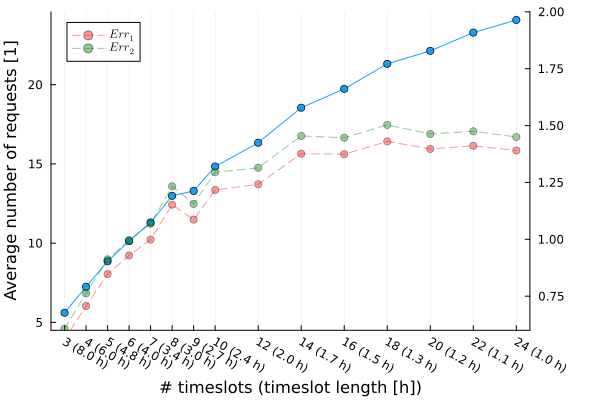

"c:\\Users\\mrkos\\scth\\projects\\MDPPricing\\notebooks\\fig_errors_nᵣ.pdf"

In [66]:
x_vals=nt
p = plot(legend=:topleft, foreground_color_legend = nothing, xrotation=-30, bottom_margin=3mm, right_margin=7mm)
plot!(p, x_vals, λ, label=false, marker=true, alpha=0.9)

xticks!(p, (x_vals, map(v->"$(v[1]) ($(@sprintf("%.1f", v[2])) h)", zip(x_vals , 24 ./ x_vals))))
xlabel!(p, "# timeslots (timeslot length [h])")
yticks!(p, [5,10,15,20])
ylabel!(p, "Average number of requests [1]")
ylims!(p, 4.5, 24.6)
# display(p)


p2 = twinx(p)
ylims!(p2, 0.6, 2)
plot!(p2, x_vals, err_1, legend=:topleft, label="\$Err_1\$", marker=true, alpha=0.4, color=:red, linestyle=:dash)
plot!(p2, x_vals, err_2, legend=:topleft, label="\$Err_2\$", marker=true, alpha=0.4, color=:green, linestyle=:dash)

display(p)
savefig("fig_errors_nᵣ.pdf")





In [ ]:
function plot_col(df, col; sort_rev=true, x_col = :expected_res)
    p = plot(legend=:topleft, foreground_color_legend = nothing, xrotation=-30, bottom_margin=3mm, right_margin=7mm)
    for method in keys(SOLVERS)
        plot_columns = sort(filter(:method=> m-> occursin(method, m), df), x_col; rev=sort_rev)
        plot!(p, plot_columns[:, x_col], plot_columns[:, col], label=false, marker=true, alpha=0.9)
        break
    end
    p
end

x_col = :nᵣ
sort_rev=false
df = df_nr

# plot_col("mean_time")
p = plot_col(df, "mean_nᵣ"; sort_rev=sort_rev, x_col=x_col)
x_vals = sort(unique(df[:, x_col]); rev=sort_rev)
xticks!(p, (x_vals, map(v->"$(v[1]) ($(@sprintf("%.1f", v[2])) h)", zip(x_vals , 24 ./ x_vals))))
xlabel!(p, "# timeslots (timeslot length [h])")
ylabel!(p, "Average number of requests [1]")

display(p)

savefig("fig_$(PP_NAME)_nᵣ.pdf")

# p = plot_col_relative(df, "mean_r"; sort_rev=sort_rev, x_col=x_col)
# x_vals = sort(unique(df[:, x_col]); rev=sort_rev)
# xticks!(p, (x_vals, map(v->"$(v[1]) ($(@sprintf("%.1f", v[2])) h)", zip(x_vals , 24 ./ x_vals))))
# xlabel!(p, "# timeslots (timeslot length [h])")
# ylabel!(p, "Ratios of average revenue")

# display(p)

# savefig("fig_$(PP_NAME)_revenue.pdf")

# Calculating state space sizes

State: (t, c, prd)
k... num timeslots
T... num timeslots

Num. products: < 2^k, for continous products: k+(k-1)+(k-2)+...+1 = k*(k+1)/2
Num. capacity vect0rs: c^k

In [11]:
using Printf
 k=1000.
 n=6.
 c=3.

 sss = k*n*(n+1)/2*c^n

 @printf "%.2E" sss




1.53E+07

In [15]:
24*24*3*10

17280

In [14]:
sss*(3*32+32+32)/10^9

2.44944

# EXP1: Testing MCTS params


##  parametric problem

In [8]:
PP_NAME = "single_day_pp_testing_MCTS"

results_orig, raw = folder_report(datadir("ev_experiments", "results", PP_NAME); raw_result_array = true);

Base.IOError: IOError: readdir("c:\\Users\\mrkos\\scth\\projects\\MDPPricing\\data\\ev_experiments\\results\\single_day_pp_testing_MCTS"): no such file or directory (ENOENT)

In [15]:
N=100
results = filter(:N=> n-> n==N, results_orig);

mcts_res = filter(:method=> m-> occursin("n_iter", m), results);
other_res = filter(:method=> m-> ~occursin("mcts", m), results);

In [16]:
# function get_mcts_params(method_name::String)
#     m = match(r"mcts_vanilla_depth=(.*)_exploration_constant=(.*)_reuse_tree=true", method_name)
#     depth, ec = m.captures
#     (mcts_depth = parse(Int64, depth), mcts_ec = parse(Float64, ec))
# end

# mcts_res = hcat(DataFrame(get_mcts_params.(mcts_res.method)), mcts_res);

In [17]:
mcts_res = hcat(DataFrame(mcts_res[!, :solver_params])[!,[:reuse_tree, :exploration_constant, :depth, :n_iterations]],
    mcts_res)

,reuse_tree,exploration_constant,depth,n_iterations,method,solver_params,pp_params_str,N,T,c,expected_res,nᵣ,objective,res_budget_μ,mean_r,median_r,min_r,max_r,mean_u,median_u,min_u,max_u,mean_nₛ,median_nₛ,min_nₛ,max_nₛ,mean_nᵣ,median_nᵣ,min_nᵣ,max_nᵣ,mean_time,median_time,min_time,max_time,mean_bytes,median_bytes,min_bytes,max_bytes
,Bool,Float64,Int64,Int64,String,Dict…,String,Int64,Int64,Int64,Int64,Int64,Symbol,Float64,Float64,Float64,Real,Real,Float64,Float64,Real,Real,Float64,Float64,Real,Real,Float64,Float64,Real,Real,Float64,Float64,Real,Real,Float64,Float64,Real,Real
1,1,1.0,10,1000,mcts_vanilla_depth=10_exploration_constant=1.0_n_iterations=1000_reuse_tree=true,"Dict(:n_iterations=>1000, :rng=>Xorshift1024Plus(0xd80cfceb459568ef, 0x9114f12fbbeae058, 0xd3b714f2f9f42f28, 0x23a608653f6ea1bf, 0x00185bd53a043344, 0xa2db1e07b8c16429, 0x3514b5c7f0f541d7, 0x7023a4e2127a81ba, 0x544d6aacf306ef6e, 0xc82440d58503a174, 0x4c707cf236d3e30a, 0x132f3dfb854c9d51, 0x780e5ce2c1a0ae43, 0xe440e857a249b4d8, 0x537b6efc4faf4abc, 0xf2ee6bdf8962fbd4, 13), :reuse_tree=>true, :exploration_constant=>1.0, :depth=>10)","Dict{Symbol, Any}(:T => 42, :c => 3, :res_budget_μ => 4.0, :nᵣ => 6, :expected_res => 12)",100,42,3,12,6,revenue,4.0,25.26,24.0,0.0,62.0,5.23,5.0,0,10,3.97,4.0,0,7,9.77,9.5,4,16,0.540327,0.333535,0.316114,3.51299,6.29939e8,6.16673e8,504415920,1153412600
2,1,1.0,10,200,mcts_vanilla_depth=10_exploration_constant=1.0_n_iterations=200_reuse_tree=true,"Dict(:n_iterations=>200, :rng=>Xorshift1024Plus(0xab4c624ad24282d8, 0x7d68110e374dee7d, 0xf4b2527447d773fb, 0x02876551fa5d8ac1, 0x9e2d9eb375ce579f, 0x74a69b4a5ade5eeb, 0x65dea79346e599f3, 0xbcddd88522ce3cf5, 0x8469882c44a1288c, 0x254b7aa9aed803b8, 0x21827c9a9cb47f5e, 0x3270901364cfae9d, 0x56a05164b4f3255c, 0xa796b5b5980a5fb6, 0x88bdd996ce9150d2, 0x9de47eb01f17ad9e, 4), :reuse_tree=>true, :exploration_constant=>1.0, :depth=>10)","Dict{Symbol, Any}(:T => 42, :c => 3, :res_budget_μ => 4.0, :nᵣ => 6, :expected_res => 12)",100,42,3,12,6,revenue,4.0,24.58,22.0,2.0,64.0,5.51,5.0,1,10,4.36,4.0,1,7,9.77,9.5,4,16,0.227526,0.124523,0.115024,5.85893,2.98187e8,2.92075e8,232736176,549387880
3,1,1.0,10,300,mcts_vanilla_depth=10_exploration_constant=1.0_n_iterations=300_reuse_tree=true,"Dict(:n_iterations=>300, :rng=>Xorshift1024Plus(0x5dec23e450519341, 0x1d3994ff7ce9bb73, 0x3a3d580d477ba423, 0xb6dc256b34fbc3cc, 0x097e744fafa4b5af, 0x35d4a5411beb4ef2, 0x46fd3a2296010e90, 0x2a009c338dbd330c, 0x83be7c816c526090, 0xaa570373b3ce4bb0, 0xfc76e95196a96cf2, 0x935d9709950f7ed2, 0xbbf1ec5715af5c17, 0x483812d38f197067, 0x531d6c5c418a7396, 0xa926c9baaeb232df, 14), :reuse_tree=>true, :exploration_constant=>1.0, :depth=>10)","Dict{Symbol, Any}(:T => 42, :c => 3, :res_budget_μ => 4.0, :nᵣ => 6, :expected_res => 12)",100,42,3,12,6,revenue,4.0,25.16,22.0,4.0,70.0,5.43,6.0,1,9,4.22,4.0,1,7,9.77,9.5,4,16,0.24339,0.116001,0.102039,4.56798,3.16267e8,2.61508e8,206874592,491345616
4,1,1.0,10,400,mcts_vanilla_depth=10_exploration_constant=1.0_n_iterations=400_reuse_tree=true,"Dict(:n_iterations=>400, :rng=>Xorshift1024Plus(0x342324529b922591, 0xf12876454597e952, 0x57c6c09b2d5d188f, 0x4453cacf242a1a2a, 0x185dc0e2a597e14d, 0x0fb913f08afdf04c, 0x93ac8068eb851e3a, 0xd8dd661db19ce316, 0x17e2a7bc597670c9, 0x8bf3e1bfa2227338, 0x13b59a04e31fffff, 0x1e13759b72708c37, 0x1b2af1665e2041f3, 0x756afc988e10be5c, 0xec4f61d1b97489e9, 0xb3773b34dbf825f3, 10), :reuse_tree=>true, :exploration_constant=>1.0, :depth=>10)","Dict{Symbol, Any}(:T => 42, :c => 3, :res_budget_μ => 4.0, :nᵣ => 6, :expected_res => 12)",100,42,3,12,6,revenue,4.0,24.34,22.0,4.0,62.0,5.4,5.5,1,10,4.24,4.0,1,7,9.77,9.5,4,16,0.441033,0.239815,0.231022,5.97603,5.67272e8,5.59115e8,433700816,1122108744
5,1,1.0,10,50,mcts_vanilla_depth=10_exploration_constant=1.0_n_iterations=50_reuse_tree=true,"Dict(:n_iterations=>50, :rng=>Xorshift1024Plus(0xe3951572d78ebd28, 0x453e65b061d4240a, 0x6784029788b7789b, 0x55a553b81e7409ab, 0xf281414b82db0f3b, 0x80a3c62d8058274e, 0xc3eecfab4bbe7f7d, 0x7

In [18]:
# mcts_res = transform(mcts_res, :method => ByRow(m->occursin("unlimited_rollout", m)*Inf) => :rollout_depth);

In [19]:
# mcts_res_old = filter(:rollout_depth=> rd-> ~ (rd==Inf), mcts_res);
# mcts_res_urd = filter(:rollout_depth=> rd-> rd==Inf, mcts_res);

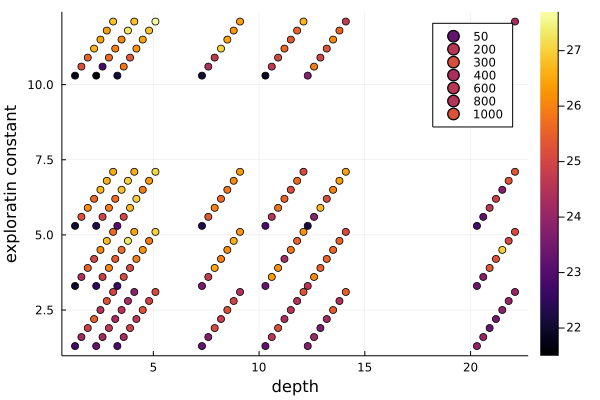

In [24]:
p=plot()
for (i, n_iter) in enumerate([50,200,300,400, 600, 800, 1000])
    df = filter(:n_iterations=> n-> n==n_iter, mcts_res);
    
    p = scatter(p, df.depth.+(0.3*i), df.exploration_constant.+(0.3*i), marker_z=df.mean_r, label=n_iter, markershape=:circle)
end

# for (i, n_iter) in enumerate([50,200,300,400, 600, 800])
#     df = filter(:n_iterations=> n-> n==n_iter, mcts_res);
    
#     p = scatter(p, df.depth.+(0.3*i).+0.1, df.exploration_constant.+(0.3*i), marker_z=df.mean_r, label=n_iter, markershape=:diamond)
# end

ylabel!(p, "exploratin constant")
xlabel!(p, "depth")

In [27]:
other_res

,method,solver_params,pp_params_str,N,T,c,expected_res,nᵣ,objective,res_budget_μ,mean_r,median_r,min_r,max_r,mean_u,median_u,min_u,max_u,mean_nₛ,median_nₛ,min_nₛ,max_nₛ,mean_nᵣ,median_nᵣ,min_nᵣ,max_nᵣ,mean_time,median_time,min_time,max_time,mean_bytes,median_bytes,min_bytes,max_bytes
,String,Dict…,String,Int64,Int64,Int64,Int64,Int64,Symbol,Float64,Float64,Float64,Real,Real,Float64,Float64,Real,Real,Float64,Float64,Real,Real,Float64,Float64,Real,Real,Float64,Float64,Real,Real,Float64,Float64,Real,Real
1,flatrate_,Dict(),"Dict{Symbol, Any}(:T => 42, :c => 3, :res_budget_μ => 4.0, :nᵣ => 6, :expected_res => 12)",100,42,3,12,6,revenue,4.0,22.36,22.0,4.0,36.0,5.59,5.5,1,9,4.4,4.0,1,7,9.77,9.5,4,16,0.00157952,0.000267167,0.000259099,0.131477,2.93236e5,102336.0,100864,19192261
2,hindsight_,Dict(),"Dict{Symbol, Any}(:T => 42, :c => 3, :res_budget_μ => 4.0, :nᵣ => 6, :expected_res => 12)",100,42,3,12,6,revenue,4.0,42.02,38.0,10.0,96.0,7.35,7.5,3,12,5.87,6.0,3,8,9.77,9.5,4,16,0.00179559,0.000233283,0.000226535,0.155921,2.94402e5,101728.0,100768,19368219
3,vi_,Dict(),"Dict{Symbol, Any}(:T => 42, :c => 3, :res_budget_μ => 4.0, :nᵣ => 6, :expected_res => 12)",100,42,3,12,6,revenue,4.0,28.4,24.0,4.0,76.0,5.41,5.0,1,9,4.34,4.0,1,7,9.77,9.5,4,16,0.00196573,0.000345287,0.000332604,0.162342,3.18418e5,163344.0,161872,15671325


In [26]:
agg_df = sort(mcts_res, :mean_r, rev=true)[!, [:exploration_constant, :depth, :n_iterations,:mean_r, :mean_time]]

,exploration_constant,depth,n_iterations,mean_r,mean_time
,Float64,Int64,Int64,Float64,Float64
1,10.0,3,1000,27.7,0.295785
2,10.0,2,800,27.3,0.215324
3,3.0,2,800,27.3,0.520018
4,5.0,3,1000,27.1,0.749338
5,10.0,7,400,27.04,0.252479
6,5.0,2,800,27.02,0.312817
7,3.0,3,1000,27.02,0.294545
8,5.0,3,400,27.0,0.350436
9,3.0,20,600,26.98,0.384644


In [46]:
f = filter(:mean_r => r->r>26.5, agg_df)
(d = median(f.depth), ec = median(f.exploration_constant), n_iter = median(f.n_iterations))

(d = 2.0, ec = 5.0, n_iter = 800.0)

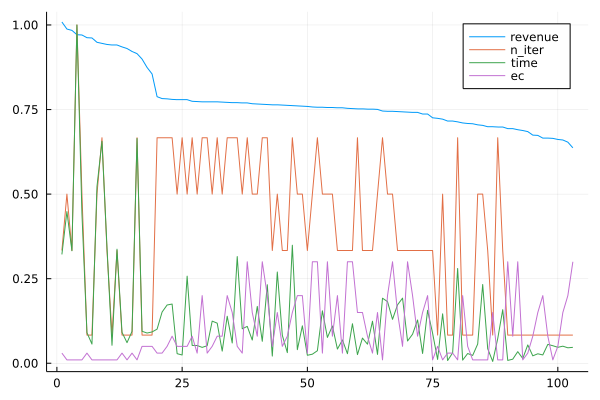

In [385]:
p = plot()
plot!(p, agg_df.mean_r./25, label="revenue")
plot!(p, agg_df.n_iterations./600, label="n_iter")
plot!(p, agg_df.mean_time./maximum(agg_df.mean_time), label="time")
plot!(p, agg_df.exploration_constant./100, label="ec")

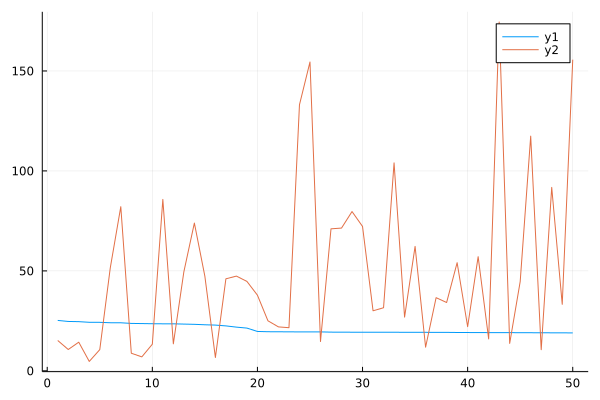

In [371]:
p = plot()
plot!(p, agg_df.mean_r[1:50])
plot!(p, (agg_df.mean_r./agg_df.mean_time)[1:50])
# plot!(p, agg_df.n_iterations./600)
# plot!(p, agg_df.mean_time./maximum(agg_df.mean_time))

In [119]:
other_res

,method,solver_params,pp_params_str,N,T,c,expected_res,nᵣ,objective,res_budget_μ,mean_r,median_r,min_r,max_r,mean_u,median_u,min_u,max_u,mean_nₛ,median_nₛ,min_nₛ,max_nₛ,mean_nᵣ,median_nᵣ,min_nᵣ,max_nᵣ,mean_time,median_time,min_time,max_time,mean_bytes,median_bytes,min_bytes,max_bytes
,String,Dict…,String,Int64,Int64,Int64,Int64,Int64,Symbol,Float64,Float64,Float64,Real,Real,Float64,Float64,Real,Real,Float64,Float64,Real,Real,Float64,Float64,Real,Real,Float64,Float64,Real,Real,Float64,Float64,Real,Real
1,flatrate_,Dict(),"Dict{Symbol, Any}(:T => 42, :c => 3, :res_budget_μ => 4.0, :nᵣ => 6, :expected_res => 12)",100,42,3,12,6,revenue,4.0,17.6,16.0,4.0,28.0,5.59,5.5,1,9,4.4,4.0,1,7,9.77,9.5,4,16,0.0017678,0.00034218,0.000330316,0.142516,2.96733e5,150144.0,148672,14808893
2,hindsight_,Dict(),"Dict{Symbol, Any}(:T => 42, :c => 3, :res_budget_μ => 4.0, :nᵣ => 6, :expected_res => 12)",100,42,3,12,6,revenue,4.0,28.34,28.0,10.0,50.0,7.35,7.5,3,12,5.87,6.0,3,8,9.77,9.5,4,16,0.00858665,0.000297333,0.000281895,0.78597,5.75032e5,149536.0,148576,42586714
3,vi_,Dict(),"Dict{Symbol, Any}(:T => 42, :c => 3, :res_budget_μ => 4.0, :nᵣ => 6, :expected_res => 12)",100,42,3,12,6,revenue,4.0,20.14,20.0,4.0,34.0,5.41,5.0,1,9,4.34,4.0,1,7,9.77,9.5,4,16,0.00292129,0.000379626,0.000354416,0.230763,4.80041e5,183984.0,182512,29790256


## Data distributions

In [157]:
depths = [3,7,10,14,20,40]
ecs = [1., 3., 8., 20.]
n_iter = [200,400,600]
params = collect(Base.product(depths, ecs, n_iter))
length(params)

72

In [158]:
PP_NAME = "cs_deggendorf_data_driven_24_MCTS_tests"

results_orig, raw = folder_report(datadir("ev_experiments", "results", PP_NAME); raw_result_array = true);

In [159]:
N=100
results = filter(:N=> n-> n==N, results_orig);

mcts_res = filter(:method=> m-> occursin("mcts", m), results);
other_res = filter(:method=> m-> ~occursin("mcts", m), results);

In [160]:
other_res

,method,solver_params,pp_params_str,N,T,c,expected_res,nᵣ,objective,res_budget_μ,mean_r,median_r,min_r,max_r,mean_u,median_u,min_u,max_u,mean_nₛ,median_nₛ,min_nₛ,max_nₛ,mean_nᵣ,median_nᵣ,min_nᵣ,max_nᵣ,mean_time,median_time,min_time,max_time,mean_bytes,median_bytes,min_bytes,max_bytes
,String,Dict…,String,Int64,Int64,Int64,Int64,Int64,Symbol,Float64,Float64,Float64,Real,Real,Float64,Float64,Real,Real,Float64,Float64,Real,Real,Float64,Float64,Real,Real,Float64,Float64,Real,Real,Float64,Float64,Real,Real
1,flatrate_,Dict(),"Dict{Symbol, Any}(:T => 192, :c => 3, :res_budget_μ => 1.0, :nᵣ => 24, :expected_res => 48)",100,192,3,48,24,revenue,1.0,19.38,20.0,11.0,27.0,22.99,23.0,13,33,19.38,20.0,11,27,42.32,42.0,30,52,0.00267121,0.00149008,0.00130529,0.125127,838731.0,709984.0,704176,13594845
2,hindsight_,Dict(),"Dict{Symbol, Any}(:T => 192, :c => 3, :res_budget_μ => 1.0, :nᵣ => 24, :expected_res => 48)",100,192,3,48,24,revenue,1.0,30.1,30.0,20.0,40.5,31.0,31.0,23,39,26.74,27.0,17,34,42.32,42.0,30,52,0.00916093,0.00135613,0.0013063,0.726026,1.13428e6,706448.0,700368,43385338


In [161]:
mcts_res.mean_r

55-element Vector{Float64}:
 16.43
 19.09
 19.68
 12.335
 16.115
 13.97
 17.015
 13.005
 16.175
 17.89
 15.44
 18.52
 19.455
  ⋮
 10.085
 13.655
 17.295
 19.33
 20.09
 14.415
 16.8
 15.015
 18.34
 14.15
 17.39
 18.54

In [162]:
mcts_res = hcat(DataFrame(mcts_res[!, :solver_params])[!,[:reuse_tree, :exploration_constant, :depth, :n_iterations]],
    mcts_res);

In [163]:
sort(unique(mcts_res.n_iterations))

3-element Vector{Int64}:
 200
 400
 600

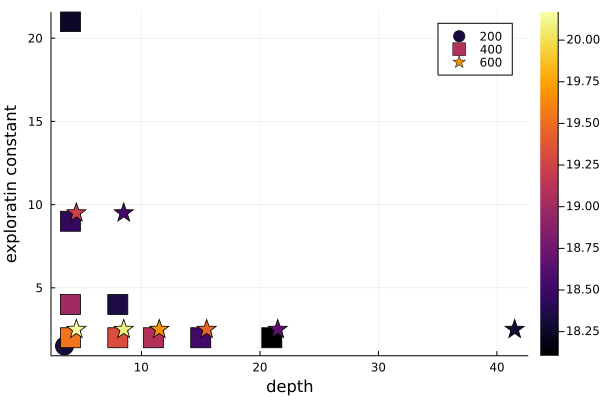

In [164]:
SHIFT=0.5
p=plot()
for (i, n_iter) in enumerate(sort(unique(mcts_res.n_iterations)))
    df = filter(:n_iterations=> n-> n==n_iter, mcts_res);
    df = filter(:mean_r=> r->r>18., df)
    p = scatter(p, df.depth.+(SHIFT*i), df.exploration_constant.+(SHIFT*i), marker_z=df.mean_r, markershape=:auto, markersize=10, label=n_iter)
end
ylabel!(p, "exploratin constant")
xlabel!(p, "depth")

In [165]:
sort(mcts_res, :mean_r, rev=true)[!, [:exploration_constant, :depth, :n_iterations,:mean_r]]

,exploration_constant,depth,n_iterations,mean_r
,Float64,Int64,Int64,Float64
1,1.0,3,600,20.17
2,1.0,7,600,20.09
3,1.0,10,600,19.68
4,1.0,3,400,19.54
5,1.0,14,600,19.455
6,1.0,7,400,19.33
7,8.0,3,600,19.23
8,1.0,10,400,19.09
9,3.0,3,400,18.985


# EXP2: Const demand experiment

In [6]:
PP_NAME = "single_day_const_demand_cs_pp"

"single_day_const_demand_cs_pp"

In [7]:
results, raw = folder_report(datadir("ev_experiments", "results", PP_NAME); raw_result_array = true);

In [8]:
print(sort(results[:, [:method, :nᵣ, :N, :mean_r, :mean_u]]));

98×5 DataFrame
 Row │ method                             nᵣ     N      mean_r    mean_u  
     │ String                             Int64  Int64  Float64   Float64 
─────┼────────────────────────────────────────────────────────────────────
   1 │ flatrate_                              3    100    2.34       2.34
   2 │ flatrate_                              3    100   18.72       2.34
   3 │ flatrate_                              4    100    3.48       3.48
   4 │ flatrate_                              4    100   20.88       3.48
   5 │ flatrate_                              5    100    4.72       4.72
   6 │ flatrate_                              5    100   22.656      4.72
   7 │ flatrate_                              6    100    5.59       5.59
   8 │ flatrate_                              6    100   22.36       5.59
   9 │ flatrate_                              7    100    6.73       6.73
  10 │ flatrate_                              7    100   23.0743     6.73
  11 │ flatrate_    

In [9]:
N=100
columns =
        [:method, :pp_params_str, :objective, :mean_r, :mean_u, :mean_bytes, :mean_time]
df_n = filter(:N => n -> n == N, results)
df_nr = filter(:objective => o -> o == :revenue, df_n);
df_nu = filter(:objective => o -> o == :utilization, df_n);

## VI and MCTS comparisons

In [36]:
df_vi = sort(filter(:method=> m-> occursin("vi", m), df_nr), :nᵣ)
df_mcts = sort(filter(:method=> m-> occursin("mcts", m), df_nr), :nᵣ)

jdf = leftjoin(df_vi, df_mcts, on=:nᵣ, renamecols = "_vi"=>"_mcts")

v = minimum(jdf.mean_r_mcts ./ jdf.mean_r_vi .*100)

println("the proposed MCTS method achieved at least $v % of revenue of the optimal pricing policy provided by the VI")

the proposed MCTS method achieved at least 93.6077057793345 % of revenue of the optimal pricing policy provided by the VI


In [55]:
max_vi_instance = PMDPs.single_day_cs_pp(;eval(Meta.parse(df_vi.pp_params_str[end]))...)
max_mcts_instance = PMDPs.single_day_cs_pp(;eval(Meta.parse(df_mcts.pp_params_str[end]))...)

PMDPs.statespace_size(max_vi_instance)
PMDPs.statespace_size(max_mcts_instance)

println("\nwe have shown MCTS scaled to up to $(14234448638642400/642978) times larger problem instances than VI (in terms of the state space)")

There are 729 capacity vectors, 42 timesteps, and 21 products
For 642978 states, each state is 62 bytes
These would take 0.039864636 GB of memory
There are 282429536481 capacity vectors, 168 timesteps, and 300 products
For 14234448638642400 states, each state is 80 bytes
These would take 1.138755891091392e9 GB of memory

we have shown MCTS scaled to up to 2.2138313657142857e10 times larger problem instances than VI (in terms of the state space)


## Plots

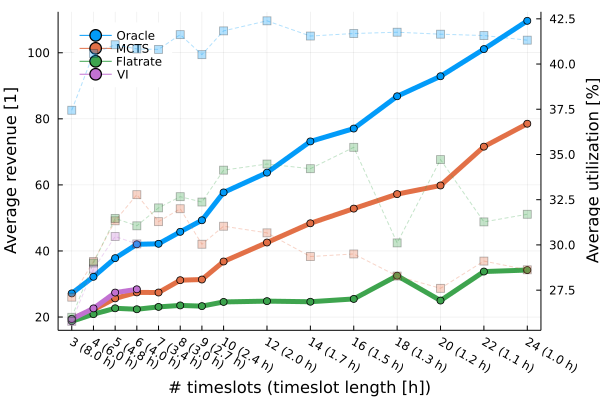

In [11]:
function plot_col(df, col; sort_rev=true, x_col = :expected_res)
    p = plot(legend=:topleft, foreground_color_legend = nothing, xrotation=-30, bottom_margin=3mm, right_margin=13mm)
    for method in keys(SOLVERS)
        plot_columns = sort(filter(:method=> m-> occursin(method, m), df), x_col; rev=sort_rev)
        plot!(p, plot_columns[:, x_col], plot_columns[:, col], label=SOLVERS[method], marker=true, alpha=0.99,  linewidth=5, thickness_scaling = 1)
    end
    p
end

x_col = :nᵣ
sort_rev=false
df = df_nr

# plot_col("mean_time")
p = plot_col(df, "mean_r"; sort_rev=sort_rev, x_col=x_col)
x_vals = sort(unique(df[:, x_col]); rev=sort_rev)
xticks!(p, (x_vals, map(v->"$(v[1]) ($(@sprintf("%.1f", v[2])) h)", zip(x_vals , 24 ./ x_vals))))
xlabel!(p, "# timeslots (timeslot length [h])")
ylabel!(p, "Average revenue [1]")


p2 = twinx(p)
for method in keys(SOLVERS)
    plot_columns = sort(filter(:method=> m-> occursin(method, m), df), x_col; rev=sort_rev)
    plot!(p2, plot_columns[:, x_col], plot_columns[:, "mean_u"]./(0.01 * 3 .* plot_columns[:, x_col]), label=SOLVERS[method], marker=:square, alpha=0.3, xticks=[], legend = false, linestyle=:dash)
end
ylabel!(p2, "Average utilization [%]")
# xticks!(p2, [])


display(p)

savefig("fig_$(PP_NAME)_revenue_util.pdf")

In [12]:
print(names(df_nr))

["method", "solver_params", "pp_params_str", "N", "T", "c", "expected_res", "nᵣ", "objective", "res_budget_μ", "mean_r", "median_r", "min_r", "max_r", "mean_u", "median_u", "min_u", "max_u", "mean_nₛ", "median_nₛ", "min_nₛ", "max_nₛ", "mean_nᵣ", "median_nᵣ", "min_nᵣ", "max_nᵣ", "mean_time", "median_time", "min_time", "max_time", "mean_bytes", "median_bytes", "min_bytes", "max_bytes"]

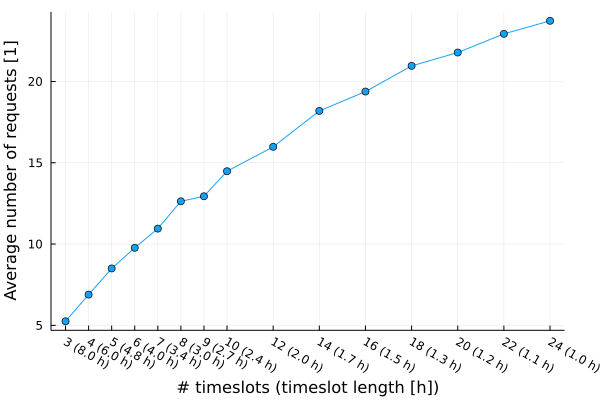

In [13]:
function plot_col(df, col; sort_rev=true, x_col = :expected_res)
    p = plot(legend=:topleft, foreground_color_legend = nothing, xrotation=-30, bottom_margin=3mm, right_margin=7mm)
    for method in keys(SOLVERS)
        plot_columns = sort(filter(:method=> m-> occursin(method, m), df), x_col; rev=sort_rev)
        plot!(p, plot_columns[:, x_col], plot_columns[:, col], label=false, marker=true, alpha=0.9)
        break
    end
    p
end

x_col = :nᵣ
sort_rev=false
df = df_nr

# plot_col("mean_time")
p = plot_col(df, "mean_nᵣ"; sort_rev=sort_rev, x_col=x_col)
x_vals = sort(unique(df[:, x_col]); rev=sort_rev)
xticks!(p, (x_vals, map(v->"$(v[1]) ($(@sprintf("%.1f", v[2])) h)", zip(x_vals , 24 ./ x_vals))))
xlabel!(p, "# timeslots (timeslot length [h])")
ylabel!(p, "Average number of requests [1]")

display(p)

savefig("fig_$(PP_NAME)_nᵣ.pdf")

# p = plot_col_relative(df, "mean_r"; sort_rev=sort_rev, x_col=x_col)
# x_vals = sort(unique(df[:, x_col]); rev=sort_rev)
# xticks!(p, (x_vals, map(v->"$(v[1]) ($(@sprintf("%.1f", v[2])) h)", zip(x_vals , 24 ./ x_vals))))
# xlabel!(p, "# timeslots (timeslot length [h])")
# ylabel!(p, "Ratios of average revenue")

# display(p)

# savefig("fig_$(PP_NAME)_revenue.pdf")

In [14]:
function boxplot_nr!(p, raw, nᵣ; objective=:revenue)
    raw_r = filter(d -> d[:pp_params][:objective]==objective && d[:pp_params][:nᵣ]==nᵣ, raw)
    df_bp = vcat(get.(raw_r, :results, nothing)...);
    df_bp.name=map(name -> "$(SOLVERS[name]) ($nᵣ)", string.(df_bp.name))
    p = @df df_bp boxplot!(p, string.(:name), :r, label="$nᵣ charging timeslots")
end

p=plot(legend=:topleft, ylabel="Revenue [1]", xlabel="Method (# timeslots)")
boxplot_nr!(p, raw, 6)
boxplot_nr!(p, raw, 12)
savefig(p, "fig_$(PP_NAME)_revenue_boxplot.pdf")
display(p)

LoadError: LoadError: UndefVarError: @df not defined
in expression starting at In[14]:5

In [15]:
Plots.supported_styles()[2:end]

5-element Vector{Symbol}:
 :solid
 :dash
 :dot
 :dashdot
 :dashdotdot

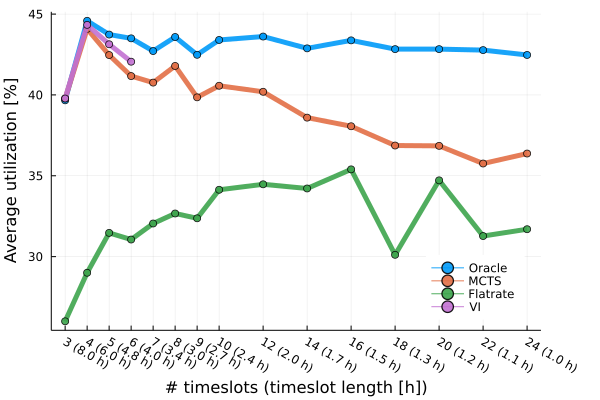

In [16]:
function plot_col(df, col; sort_rev=true, x_col = :expected_res)
    x_col_vals = 3 .* sort(unique(df[:, x_col]); rev=sort_rev)
    p = plot(legend=:bottomright, foreground_color_legend = nothing, xrotation=-30, bottom_margin=3mm, right_margin=13mm)
    for method in keys(SOLVERS)
        plot_columns = sort(filter(:method=> m-> occursin(method, m), df), x_col; rev=sort_rev)
        y_vals = plot_columns[:, col]
        plot!(p, plot_columns[:, x_col], y_vals ./ (0.01 * 3 .* plot_columns[:, x_col]), label=SOLVERS[method], marker=true, alpha=0.9, linewidth=5, thickness_scaling = 1)
    end
    p
end

x_col = :nᵣ
sort_rev=false
df = df_nu

p = plot_col(df, "mean_u"; sort_rev=sort_rev, x_col=x_col)
x_vals = sort(unique(df[:, x_col]); rev=sort_rev)
xticks!(p, (x_vals, map(v->"$(v[1]) ($(@sprintf("%.1f", v[2])) h)", zip(x_vals , 24 ./ x_vals))))
xlabel!(p, "# timeslots (timeslot length [h])")
ylabel!(p, "Average utilization [%]")


# p2 = twinx(p)
# for method in keys(SOLVERS)
#     plot_columns = sort(filter(:method=> m-> occursin(method, m), df), x_col; rev=sort_rev)
#     plot!(p2, plot_columns[:, x_col], plot_columns[:, "mean_r"], label=SOLVERS[method], marker=:square, alpha=0.3, xticks=[], legend = false, linestyle=:dash)
# end
# ylabel!(p2, "Average revenue [1]")
# # xticks!(p2, [])


display(p)

savefig("fig_$(PP_NAME)_utilization_rev.pdf")

In [17]:
function boxplot_nr!(p, raw, nᵣ; objective=:revenue)
    raw_r = filter(d -> d[:pp_params][:objective]==objective && d[:pp_params][:nᵣ]==nᵣ, raw)
    df_bp = vcat(get.(raw_r, :results, nothing)...);
    df_bp.name=map(name -> "$(SOLVERS[name]) ($nᵣ)", string.(df_bp.name))
    p = @df df_bp boxplot!(p, string.(:name), :r ./ (0.01*nᵣ*3), label="$nᵣ charging timeslots")
end

p=plot(legend=:topleft, ylabel="Utilization [%]", xlabel="Method (# timeslots)")
boxplot_nr!(p, raw, 6, objective=:utilization)
boxplot_nr!(p, raw, 12, objective=:utilization)
savefig(p, "fig_$(PP_NAME)_utilization_boxplot.pdf")
display(p)

LoadError: LoadError: UndefVarError: @df not defined
in expression starting at In[17]:5

### Investigate raw

In [26]:
display("text/html", "<style>.container { width:100% !important; }</style>")

In [94]:
raw_u = filter(d -> d[:pp_params][:objective]==:utilization && d[:pp_params][:nᵣ]==3, raw)
d_flat = raw_u[1]
d_hind = raw_u[2]
d_mcts = raw_u[3]
d_vi = raw_u[4]

Dict{Symbol, Any} with 11 entries:
  :solver_params => Dict{Any, Any}()
  :pp_params     => Dict{Symbol, Any}(:T=>21, :c=>3, :res_budget_μ=>8.0, :objective=>:utilization, :nᵣ=>3, :expected_res=>6)
  :agg           => 6×7 DataFrame…
  :N             => 100
  :method_info   => ""
  :results       => 100×11 DataFrame…
  :overall_stats => (time = 5.88357, bytes = 778130519, gctime = 0.181237, gcstats = GC_Diff(778130519, 764, 0, 13583585, 2795, 0, 181237396, 5, 0))
  :problem_name  => "single_day_const_demand_cs_pp"
  :method        => "vi"
  :kwargs        => Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}()
  :info          => ""

In [119]:
trace_data

Dict{String, Any} with 3 entries:
  "jld2_data" => Dict{Symbol, Any}(:pp=>PMDPProblem{:utilization}(PMDPs.Product[[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 1, 0], [0, 1, 1], [1, 1, 1]], [3, 3, 3], 21, StaggeredBernoulliScheme([7, 14, 21, 7, 14, 7], [0.073486, 0.329463, 0.0244953, 0.00255303, 0.0114461, 0.000118262], Categorical{P, Ps} where {P<:Real, Ps<:AbstractVector{P}}[Categorical{Float64, Vector{Float64}}(…
  "gitcommit" => "46a2f6b08661194701c1706fc466136214a4deca-dirty"
  "script"    => "src/PMDPs/src/simulations/simrunning.jl#183"

In [122]:
using JLD2
using PMDPs

trace_data = JLD2.load("/home/mrkos/projects/MDPPricing/data/ev_experiments/traces/single_day_const_demand_cs_pp_N=1000_T=21_c=3_expected_res=6_nᵣ=3_objective=utilization_res_budget_μ=8.0.jld2")
traces = trace_data["jld2_data"][:traces]
traces = traces[1:size(d_mcts[:results], 1)]

pp = trace_data["jld2_data"][:pp];

PMDPs.PMDPe(PMDPs.PMDPProblem{:utilization}(PMDPs.Product[[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 1, 0], [0, 1, 1], [1, 1, 1]], [3, 3, 3], 21, PMDPs.CountingProcesses.StaggeredBernoulliScheme([7, 14, 21, 7, 14, 7], [0.07348603295969605, 0.3294627608957592, 0.024495344319898676, 0.0025530315933561137, 0.011446104838215006, 0.00011826229745815198], Categorical{P, Ps} where {P<:Real, Ps<:AbstractVector{P}}[Categorical{Float64, Vector{Float64}}(
support: Base.OneTo(7)
p: [0.07348603295969605, 0.3294627608957592, 0.024495344319898676, 0.0025530315933561137, 0.011446104838215006, 0.00011826229745815198, 0.5584384630956167]
)
, Categorical{Float64, Vector{Float64}}(
support: Base.OneTo(7)
p: [0.07348603295969605, 0.3294627608957592, 0.024495344319898676, 0.0025530315933561137, 0.011446104838215006, 0.00011826229745815198, 0.5584384630956167]
)
, Categorical{Float64, Vector{Float64}}(
support: Base.OneTo(7)
p: [0.07348603295969605, 0.3294627608957592, 0.024495344319898676, 0.0025530315933561137, 

In [129]:
me = PMDPs.PMDPe(pp);

In [181]:
# Show requested products in trace

h = traces[2];
function non_empty_products(h::AbstractSimHistory)
    non_empty_p = collect([pp.P[s.iₚ] for s in h[:s] if s.iₚ!=PMDPs.empty_product_id(me)])
    prod_signatures = map(p->*(string.(Int64.(p))...), non_empty_p)
    join(prod_signatures, "-")
end
non_empty_products(h)

"010-010-001"

In [141]:
# Show requests in trace

h = traces[2];

function requested_product_size_sequence(h::AbstractSimHistory)
    requested_product_lengths = collect([s.iₚ == PMDPs.empty_product_id(me) ? 0 : sum(pp.P[s.iₚ]) for s in h[:s]])
    sequence = *(string.(requested_product_lengths)...)
end

requested_product_size_sequence(h)


"00010000001000000001"

In [182]:
trace_sequences = DataFrame(:requests_sizes=> map(requested_product_size_sequence, traces), :non_empty_prods=> map(non_empty_products, traces));

In [160]:
d = d_hind
d[:agg]
d[:results];

In [199]:
cols = [:name, :r, :u, :nₛ, :nᵣ, ]
rows = d_hind[:results][:, :u] .< d_mcts[:results][:, :u] # different rows
# rows = (ones(Bool, size(d_hind[:results], 1))) # all rows

bad_results=hcat(d_hind[:results][rows, cols], d_mcts[:results][rows, cols], trace_sequences[rows, :] , makeunique=true)
print(bad_results)

43×12 DataFrame
 Row │ name       r        u      nₛ     nᵣ     name_1  r_1      u_1    nₛ_1   nᵣ_1   requests_sizes        non_empty_prods                   
     │ Symbol     Float64  Int64  Int64  Int64  Symbol  Float64  Int64  Int64  Int64  String                String                            
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ hindsight      3.0      3      3      6  mcts        4.0      4      4      6  01010010000101000001  010-010-010-010-010-001
   2 │ hindsight      3.0      3      3      8  mcts        5.0      5      5      8  00101111101010000000  001-010-010-010-001-010-010-010
   3 │ hindsight      4.0      4      4      6  mcts        5.0      5      5      6  00001100001111000000  100-100-010-010-010-010
   4 │ hindsight      4.0      4      4      6  mcts        5.0      5      5      6  01000110010100001000  010-010-010-001-010-001
   5 │ hindsight   

In [193]:
PMDPs.objective(me)

:utilization

In [200]:
i=6
h = traces[rows][i]
print(bad_results[i, :])
fp = PMDPs.LP.get_MILP_hindsight_policy(me, h)
fp

DataFrameRow
 Row │ name       r        u      nₛ     nᵣ     name_1  r_1      u_1    nₛ_1   nᵣ_1   requests_sizes        non_empty_prods 
     │ Symbol     Float64  Int64  Int64  Int64  Symbol  Float64  Int64  Int64  Int64  String                String          
─────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   6 │ hindsight      3.0      3      3      4  mcts        4.0      4      4      4  00011100100000000000  010-010-100-010

FunctionPolicy{PMDPs.LP.var"#28#30"{Dict{Int64, Float64}}}(PMDPs.LP.var"#28#30"{Dict{Int64, Float64}}(Dict(5 => 8.0, 4 => 4.0, 6 => 1.7976931348623157e308, 9 => 4.0)))

In [218]:
using Debugger

In [205]:
mdp = me

(objective_val, u, alloc, action_seq, requests) =
    PMDPs.LP.MILP_hindsight_pricing(mdp, h; objective = PMDPs.objective(mdp))

timesteps = collect([req[:s].t for req in requests])
pd = Dict(zip(timesteps, action_seq))
hp = FunctionPolicy(s -> get(pd, s.t, PMDPs.REJECT_ACTION))


4.0

In [224]:
using Gurobi, GLPK
using JuMP
using PMDPs
using POMDPSimulators
using POMDPPolicies
using POMDPs
using Suppressor

In [220]:
trace = collect(eachstep(h, "s, info"))
requests = [rec for rec in trace if rec.s.iₚ != PMDPs.empty_product_id(mdp)]


4-element Vector{NamedTuple{(:s, :info), Tuple{PMDPs.State, NamedTuple{(:b,), Tuple{Float64}}}}}:
 (s = c:[3, 3, 3]_t:4_p:2, info = (b = 5.559973790690946,))
 (s = c:[3, 3, 3]_t:5_p:2, info = (b = 11.034134147418515,))
 (s = c:[3, 3, 3]_t:6_p:1, info = (b = 2.186551296445918,))
 (s = c:[3, 3, 3]_t:9_p:2, info = (b = 4.296778020348755,))

In [223]:
request_resources = [[PMDPs.product(mdp, rec.s)...] for rec in requests]
request_budgets = [rec.info.b for rec in requests]


4-element Vector{Float64}:
  5.559973790690946
 11.034134147418515
  2.186551296445918
  4.296778020348755

In [226]:
E = request_resources
R = [PMDPs.LP.optimal_price(b, POMDPs.actions(mdp)) for b in request_budgets]


4-element Vector{Float64}:
 4.0
 8.0
 0.0
 4.0

In [230]:
capacity_constraints = [PMDPs.pp(mdp).c₀...]

request_ind = 1:length(request_resources)
capacity_ind = 1:length(capacity_constraints)

1:3

In [234]:
local model
model = Model(GLPK.Optimizer)

A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: GLPK

In [235]:
@variable(model, x[request_ind], Bin)

1-dimensional DenseAxisArray{VariableRef,1,...} with index sets:
    Dimension 1, 1:4
And data, a 4-element Vector{VariableRef}:
 x[1]
 x[2]
 x[3]
 x[4]

In [236]:
@constraint(
    model,
    [j in capacity_ind],
    sum(x[i] * E[i][j] for i in request_ind) <= capacity_constraints[j]
)

1-dimensional DenseAxisArray{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.LessThan{Float64}}, ScalarShape},1,...} with index sets:
    Dimension 1, 1:3
And data, a 3-element Vector{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.LessThan{Float64}}, ScalarShape}}:
 x[3] ≤ 3.0
 x[1] + x[2] + x[4] ≤ 3.0
 0 ≤ 3.0

In [238]:
durations = [sum(rec) for rec in E]
@objective(model, Max, sum(x[i] * durations[i] for i in request_ind))

x[1] + x[2] + x[3] + x[4]

In [239]:
output = @capture_out optimize!(model)

""

In [245]:
utilization = sum(sum([x * p for (x, p) in zip(optimal_alloc.data, request_resources)]))


4.0

In [243]:
status = termination_status(model)
obj_val = objective_value(model)
optimal_alloc = JuMP.value.(x)

1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, 1:4
And data, a 4-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0

In [246]:
action_seq = [(alloc == 1.0 ? r : PMDPs.REJECT_ACTION) for (alloc, r) in zip(optimal_alloc.data, R)]

4-element Vector{Float64}:
 4.0
 8.0
 1.7976931348623157e308
 4.0

In [212]:
PMDPs.actions(me)

10-element Vector{Float64}:
  0.0
  4.0
  8.0
 12.0
 16.0
 20.0
 24.0
 28.0
 32.0
  1.7976931348623157e308

In [217]:
PMDPs.LP.optimal_price(5., PMDPs.actions(me))

4.0

In [211]:
println(objective_val, u, alloc, action_seq, )
for r in requests
    println(r)
end

4.04.0[1.0, 1.0, 1.0, 1.0][4.0, 8.0, 1.7976931348623157e308, 4.0]
(s = c:[3, 3, 3]_t:4_p:2, info = (b = 5.559973790690946,))
(s = c:[3, 3, 3]_t:5_p:2, info = (b = 11.034134147418515,))
(s = c:[3, 3, 3]_t:6_p:1, info = (b = 2.186551296445918,))
(s = c:[3, 3, 3]_t:9_p:2, info = (b = 4.296778020348755,))


# EXP3 Deggendorf data distributions experiment

n\_r = 24
Threads=12:

 926.17s user 20.31s system 565% cpu 2:47.26 total
 +
 18901.35s user 1183.91s system 424% cpu 1:18:46.98 total

In [56]:
nᵣ=48
# PP_NAME = "cs_deggendorf_data_driven_$(nᵣ)"
PP_NAME = "cs_var_demand_$(nᵣ)"

"cs_var_demand_48"

In [57]:
results, raw = folder_report(datadir("ev_experiments", "results", PP_NAME); raw_result_array = true);

In [59]:
N=100
# columns =
#         [:method, :pp_params_str, :objective, :mean_r, :mean_u, :mean_bytes, :mean_time]
df_n = filter(:N => n -> n == N, results)
df_nr = filter(:objective => o -> o == :revenue, df_n)
df_nu = filter(:objective => o -> o == :utilization, df_n)

,method,solver_params,pp_params_str,N,T,c,expected_res,nᵣ,objective,res_budget_μ,mean_r,median_r,min_r,max_r,mean_u,median_u,min_u,max_u,mean_nₛ,median_nₛ,min_nₛ,max_nₛ,mean_nᵣ,median_nᵣ,min_nᵣ,max_nᵣ,mean_time,median_time,min_time,max_time,mean_bytes,median_bytes,min_bytes,max_bytes
,String,Dict…,String,Int64,Int64,Int64,Float64,Int64,Symbol,Float64,Float64,Float64,Real,Real,Float64,Float64,Real,Real,Float64,Float64,Real,Real,Float64,Float64,Real,Real,Float64,Float64,Real,Real,Float64,Float64,Real,Real
1,flatrate_,Dict(),"Dict{Symbol, Any}(:T => 144, :c => 3, :res_budget_μ => 0.5, :nᵣ => 48, :expected_res => 72.0)",100,144,3,72.0,48,utilization,0.5,40.12,39.0,19.0,73.0,40.12,39.0,19,73,8.56,9.0,4,13,24.8,25.0,14,34,0.000930251,0.000929128,0.000913268,0.000978286,3.68554e5,368584.0,361264,374960
2,flatrate_,Dict(),"Dict{Symbol, Any}(:T => 192, :c => 3, :res_budget_μ => 0.5, :nᵣ => 48, :expected_res => 96.0)",100,192,3,96.0,48,utilization,0.5,44.77,46.5,24.0,70.0,44.77,46.5,24,70,8.18,8.0,5,12,33.2,33.0,22,43,0.0012459,0.0012455,0.00123248,0.00127839,4.96085e5,496648.0,490096,500944
3,flatrate_,Dict(),"Dict{Symbol, Any}(:T => 240, :c => 3, :res_budget_μ => 0.5, :nᵣ => 48, :expected_res => 120.0)",100,240,3,120.0,48,utilization,0.5,49.11,49.0,30.0,83.0,49.11,49.0,30,83,9.34,9.0,6,14,41.47,42.0,25,60,0.00159634,0.0015763,0.0015491,0.00188368,618399.0,618480.0,609552,629376
4,flatrate_,Dict(),"Dict{Symbol, Any}(:T => 288, :c => 3, :res_budget_μ => 0.5, :nᵣ => 48, :expected_res => 144.0)",100,288,3,144.0,48,utilization,0.5,52.44,52.0,33.0,73.0,52.44,52.0,33,73,10.25,10.0,6,16,49.74,51.0,33,61,0.00164761,0.00159095,0.00155529,0.00178644,7.4068e5,741360.0,732640,747696
5,flatrate_,Dict(),"Dict{Symbol, Any}(:T => 336, :c => 3, :res_budget_μ => 0.5, :nᵣ => 48, :expected_res => 168.0)",100,336,3,168.0,48,utilization,0.5,58.61,59.0,35.0,90.0,58.61,59.0,35,90,13.38,13.0,9,19,58.83,59.5,37,76,0.00195505,0.00191954,0.00182643,0.00208959,8.6439e5,864856.0,851328,875104
6,flatrate_,Dict(),"Dict{Symbol, Any}(:T => 48, :c => 3, :res_budget_μ => 0.5, :nᵣ => 48, :expected_res => 24.0)",100,48,3,24.0,48,utilization,0.5,14.22,12.5,0.0,43.0,14.22,12.5,0,43,2.33,2.0,0,6,7.9,8.0,2,13,0.000312177,0.00031117,0.000300263,0.000348336,1.21825e5,121728.0,117664,125184
7,flatrate_,Dict(),"Dict{Symbol, Any}(:T => 96, :c => 3, :res_budget_μ => 0.5, :nᵣ => 48, :expected_res => 48.0)",100,96,3,48.0,48,utilization,0.5,30.66,29.0,7.0,53.0,30.66,29.0,7,53,6.33,6.0,1,12,16.33,16.0,4,26,0.000621289,0.000619985,0.000604768,0.000665489,2.45577e5,245704.0,236672,252176
8,hindsight_,Dict(),"Dict{Symbol, Any}(:T => 144, :c => 3, :res_budget_μ => 0.5, :nᵣ => 48, :expected_res => 72.0)",100,144,3,72.0,48,utilization,0.5,53.17,53.0,33.0,81.0,53.17,53.0,33,81,15.76,16.0,9,24,24.8,25.0,14,34,0.000877665,0.000875087,0.000799111,0.000963416,3.6709e5,367088.0,360128,374992
9,hindsight_,Dict(),"Dict{Symbol, Any}(:T => 192, :c => 3, :res_budget_μ => 0.5, :nᵣ => 48, :expected_res => 96.0)",100,192,3,96.0,48,utilization,0.5,62.49,62.0,43.0,92.0,62.49,62.0,43,92,17.01,16.0,10,25,33.2,33.0,22,43,0.00117587,0.00116444,0.00106644,0.00169769,4.9137e5,490744.0,484352,499168


## MCTS and flatrate comparison

In [79]:
mcts = sort(filter(:method=> m-> occursin("mcts", m), df_nr), :expected_res)
flat = sort(filter(:method=> m-> occursin("flatrate", m), df_nr), :expected_res)

v = maximum(mcts.mean_r ./ flat.mean_r)
println("MCTS method always achieved higher revenue for CS operators than the one realized by the flat-rate scheme, with up to $v higher revenues.")

v = 100 - minimum(mcts.mean_u ./ flat.mean_u)*100
println("However, our results indicate that such revenue-maximizing optimization leads up to $v % lower utilization of the charging station.")

MCTS method always achieved higher revenue for CS operators than the one realized by the flat-rate scheme, with up to 3.49958263772955 higher revenues.
However, our results indicate that such revenue-maximizing optimization leads up to 8.124652198107938 % lower utilization of the charging station.


In [81]:
mcts.mean_u ./ flat.mean_u

7-element Vector{Float64}:
 1.3164556962025316
 1.0772994129158513
 1.0727816550348954
 1.1297744025016752
 1.1419262879250662
 1.1477879481311977
 1.100665415458113

In [80]:
mcts = sort(filter(:method=> m-> occursin("mcts", m), df_nu), :expected_res)
flat = sort(filter(:method=> m-> occursin("flatrate", m), df_nu), :expected_res)


v = maximum(mcts.mean_u ./ flat.mean_u)
println("evertheless, when optimizing utilization, MCTS could deliver up to $v improvement above the flat rate")

evertheless, when optimizing utilization, MCTS could deliver up to 1.3164556962025316 improvement above the flat rate


## Plots

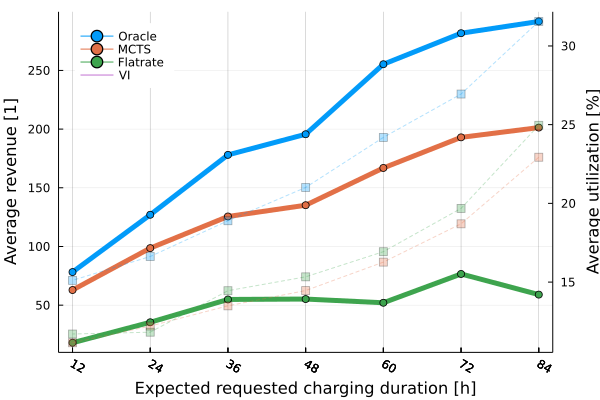

In [74]:
df = df_nr;

function plot_col(df, col; sort_rev=true, x_col = :expected_res)
    p = plot(legend=:topleft, foreground_color_legend = nothing, xrotation=-30, right_margin=10mm)
    for method in keys(SOLVERS)
        plot_columns = sort(filter(:method=> m-> occursin(method, m), df), x_col; rev=sort_rev)
        plot!(p, plot_columns[:, x_col], plot_columns[:, col], label=SOLVERS[method], marker=true, alpha=0.99, linewidth=5, thickness_scaling = 1)
    end
    xlabel!(p, String(x_col))
    ylabel!(p, col)
    return p
end

x_col = :expected_res

p = plot_col(df, "mean_r"; sort_rev=true, x_col = x_col)
xlabel!(p, "Expected demand [# timeslots]")
ylabel!(p, "Average revenue [1]")

x_vals = df.expected_res
xticks!(p, (x_vals, string.(Int64.(x_vals .*30 ./60))))
xlabel!(p, "Expected requested charging duration [h]")

p2 = twinx(p)
for method in keys(SOLVERS)
    plot_columns = sort(filter(:method=> m-> occursin(method, m), df), x_col; rev=false)
    plot!(p2, reverse(plot_columns[:, x_col]), plot_columns[:, "mean_u"]./(0.01 * 3 .* plot_columns[:, x_col]), label=SOLVERS[method], marker=:square, alpha=0.3, xticks=[], legend = false, linestyle=:dash)
end
ylabel!(p2, "Average utilization [%]")


display(p)
savefig(p, "fig_$(PP_NAME)_revenue_util.pdf")

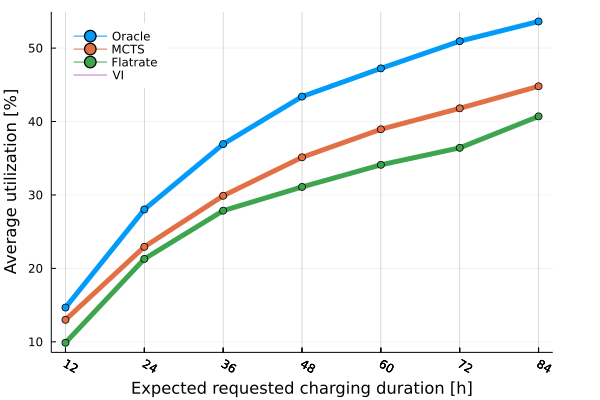

In [61]:
df = df_nu;

function plot_col(df, col; sort_rev=true, x_col = :expected_res)
    p = plot(legend=:topleft, foreground_color_legend = nothing, xrotation=-30, right_margin=10mm)
    for method in keys(SOLVERS)
        plot_columns = sort(filter(:method=> m-> occursin(method, m), df), x_col; rev=sort_rev)
        plot!(p, plot_columns[:, x_col], plot_columns[:, col] ./(0.01*nᵣ*3), label=SOLVERS[method], marker=true,  alpha=0.99, linewidth=5, thickness_scaling = 1)
    end
    xlabel!(p, String(x_col))
    ylabel!(p, col)
    return p
end

p = plot_col(df, "mean_u"; sort_rev=false)
xlabel!(p, "Expected demand [# timeslots]")
ylabel!(p, "Average utilization [%]")

x_vals = df.expected_res
xticks!(p, (x_vals, string.(Int64.(x_vals .*30 ./60))))
xlabel!(p, "Expected requested charging duration [h]")

# p2 = twinx(p)
# for method in keys(SOLVERS)
#     plot_columns = sort(filter(:method=> m-> occursin(method, m), df), x_col; rev=sort_rev)
#     plot!(p2, plot_columns[:, x_col], plot_columns[:, "mean_r"], label=SOLVERS[method], marker=:square, alpha=0.3, xticks=[], legend = false, linestyle=:dash)
# end
# ylabel!(p2, "Average revenue [1]")

display(p)
savefig(p, "fig_$(PP_NAME)_utilization.pdf")

Legend:

nₛ = n_sales
nᵣ = n_requests

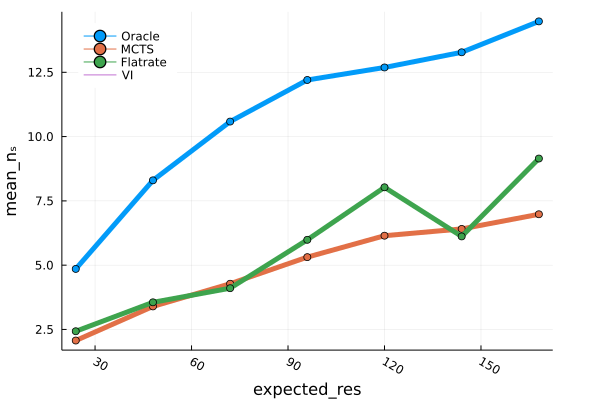

In [62]:
p = plot_col(df_nr, "mean_nₛ"; sort_rev=false, x_col = :expected_res)

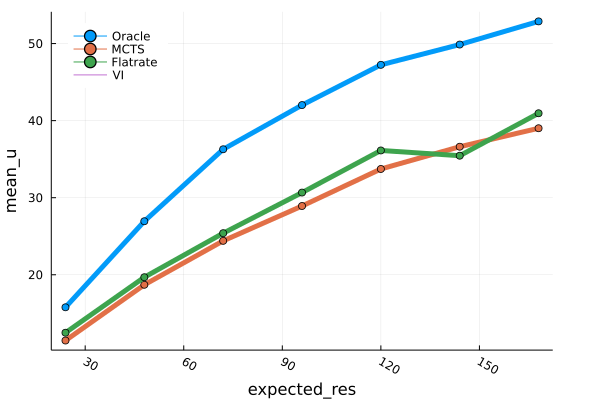

In [63]:
p = plot_col(df_nr, "mean_u"; sort_rev=false, x_col = :expected_res)

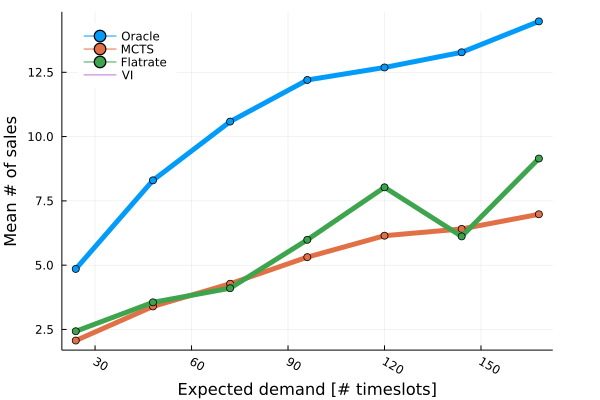

In [64]:
p = plot_col(df_nr, "mean_nₛ"; sort_rev=false, x_col = :expected_res)
xlabel!(p, "Expected demand [# timeslots]")
ylabel!(p, "Mean # of sales")

## raw data

In [69]:
using JLD2
using PMDPs

traces = JLD2.load("/home/mrkos/projects/MDPPricing/data/ev_experiments/traces/cs_deggendorf_data_driven_N=1000_T=1536_c=3_expected_res=192.0_nᵣ=48_objective=revenue_res_budget_μ=1.0.jld2")

In [73]:
pp.P

1176-element Vector{PMDPs.Product}:
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
 ⋮
 [0, 0, 0, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
 [0, 0, 0, 0, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1

In [72]:
traces["jld2_data"]

Dict{Symbol, Any} with 5 entries:
  :pp        => PMDPProblem(PMDPs.Product[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  …  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 0, 0, 0], [0, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 0, 0], [0, 0, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [0, 0, 0, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1

In [63]:
h = traces["jld2_data"][:traces][1];
pp = traces["jld2_data"][:pp];

non_empty_p = collect([pp.P[s.iₚ] for s in h[:s] if s.iₚ!=1177])
for p in non_empty_p
    print(*(string.(Int64.(p))...))
    println(" ", sum(p))
end

In [117]:
sum(non_empty_p, dims=1)

1-element Vector{Vector{Int64}}:
 [15, 16, 17, 17, 17, 16, 15, 15, 15, 12  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]